In [1]:
import json
import csv

import sys
sys.path.append("../../")
sys.path.append("/home/rosa/DefmodEnv/lib/python3.7/site-packages/")

import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
import math
import pickle

import implicitmodules.torch as dm
from implicitmodules.torch.HamiltonianDynamic import Hamiltonian, shoot
from implicitmodules.torch.MultiShape import MultiShapeHamiltonian
from implicitmodules.torch.Attachment.attachment_varifold import VarifoldAttachment2D

torch.set_default_tensor_type(torch.DoubleTensor)
dtype = torch.float64

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


/home/rosa/DefmodEnv/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
with open('../../data/nutsdata.pickle', 'rb') as f:
            lines, sigv, sig = pickle.load(f)

source = torch.tensor(lines[0][::2], requires_grad=True, dtype=torch.float64)[1:]
target = torch.tensor(lines[1][::2]  , requires_grad=True, dtype=torch.float64)[1:]


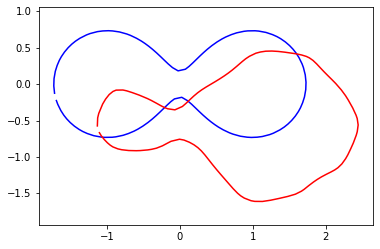

In [3]:
plt.plot(source[:,0].detach(), source[:,1].detach(), '-b')
plt.plot(target[:,0].detach(), target[:,1].detach(), '-r')
plt.axis('equal')
plt.show()

In [4]:
source0 = source
source1 = source + torch.ones(len(source),1) * torch.tensor([[1.5, 2]])

target0 = -target + torch.ones(len(target),1) * torch.tensor([[0, 0]])
target1 = target + torch.ones(len(target),1) * torch.tensor([[1.5, 2.5]])

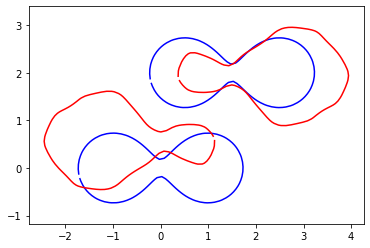

In [5]:
plt.plot(source0[:,0].detach(), source0[:,1].detach(), '-b')
plt.plot(source1[:,0].detach(), source1[:,1].detach(), '-b')
plt.plot(target0[:,0].detach(), target0[:,1].detach(), '-r')
plt.plot(target1[:,0].detach(), target1[:,1].detach(), '-r')
plt.axis('equal')
plt.show()

In [6]:
# take only every second point in the boundary to reduce computation. maybe later fix with keops
boundary0 = dm.MultiShape.Boundary(source0[::2,:].contiguous())
boundary1 = dm.MultiShape.Boundary(source1[::2,:].contiguous())

source_deformable0 = dm.Models.DeformablePoints(source0)
source_deformable1 = dm.Models.DeformablePoints(source1)
target_deformable0 = dm.Models.DeformablePoints(target0)
target_deformable1 = dm.Models.DeformablePoints(target1)

scale_scaling = 1.
scaling00 = dm.DeformationModules.LocalScaling(2, scale_scaling, gd=torch.tensor([[-1.,0.]], dtype=torch.float64, requires_grad=True))
scaling01 = dm.DeformationModules.LocalScaling(2, scale_scaling, gd=torch.tensor([[1.,0.]], dtype=torch.float64, requires_grad=True))
scaling10 = dm.DeformationModules.LocalScaling(2, scale_scaling, gd=torch.tensor([[0.5,2.]], dtype=torch.float64, requires_grad=True))
scaling11 = dm.DeformationModules.LocalScaling(2, scale_scaling, gd=torch.tensor([[2.5,2.]], dtype=torch.float64, requires_grad=True))

scale_translation = 10.
translation0 = dm.DeformationModules.Translations(2, 1, scale_translation, gd=torch.tensor([[0., 0.]]))
translation0.to_(dtype)
translation1 = dm.DeformationModules.Translations(2, 1, scale_translation, gd=torch.tensor([[1.5, 2.]]))
translation1.to_(dtype)

compound_man = dm.MultiShape.MultishapeCompoundManifold.MultishapeCompoundManifold(
    [dm.Manifolds.CompoundManifold([source_deformable0.silent_module.manifold.clone(requires_grad=True), scaling00.manifold.clone(requires_grad=True), scaling01.manifold.clone(requires_grad=True), translation0.manifold.clone(requires_grad=True), boundary0.silent_module.manifold.clone(requires_grad=True)]), 
     dm.Manifolds.CompoundManifold([source_deformable1.silent_module.manifold.clone(requires_grad=True), scaling10.manifold.clone(requires_grad=True), scaling11.manifold.clone(requires_grad=True), translation1.manifold.clone(requires_grad=True), boundary1.silent_module.manifold.clone(requires_grad=True)]), 
     dm.Manifolds.CompoundManifold([boundary0.silent_module.manifold.clone(requires_grad=True), boundary1.silent_module.manifold.clone(requires_grad=True)])])
sigma_bck = 0.5

sigmas_varifold = [2.]
attach = dm.Attachment.VarifoldAttachment(2, sigmas_varifold)


shoot_solver = 'torch_euler'
shoot_it = 10

constraints0 = dm.Constraints.Constraints.ConstraintsPointIdentityBackground(0, compound_man)
constraints1 = dm.Constraints.Constraints.ConstraintsPointIdentityBackground(1, compound_man)
constraints = dm.Constraints.Constraints.CompoundConstraints([constraints0, constraints1])

model = dm.Models.RegistrationModelMultishape([boundary0, boundary1], [source_deformable0, source_deformable1], [[scaling00, scaling01, translation0], [scaling10, scaling11, translation1]], [attach, attach], sigma_bck, lam=3., constraints=constraints)
multishape = dm.MultiShape.MultiShape.MultiShapeModules(model.modules, sigma_bck)

In [7]:
multishape.manifold.fill_gd(model.init_manifold.gd)
multishape.manifold.fill_cotan(model.init_manifold.cotan)
Ham = MultiShapeHamiltonian.Hamiltonian_multishape(multishape, constraints)


In [8]:
fitter = dm.Models.Fitter(model)
shoot_solver = 'torch_euler'
costs = fitter.fit([target_deformable0, target_deformable1], 40, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it})

Starting optimization with method Scipy L-BFGS-B
Initial cost={'deformation': 0.0, 'attach': 20.10066210431404}
Time: 102.68972283900075
Iteration: 0
Costs
deformation=0.394958041406412
attach=10.387805892924405
Total cost=10.782763934330816
Time: 127.65348579199781
Iteration: 1
Costs
deformation=3.2742737222285134
attach=1.2621427983721105
Total cost=4.536416520600624
Time: 150.732749109
Iteration: 2
Costs
deformation=2.8348813759796636
attach=1.3725535588573905
Total cost=4.207434934837054
Time: 171.52893075500106
Iteration: 3
Costs
deformation=2.6564193824842945
attach=1.473443743493192
Total cost=4.1298631259774865
Time: 194.63414938400092
Iteration: 4
Costs
deformation=2.5938938733060404
attach=1.4602569649333788
Total cost=4.054150838239419
Time: 222.04569697099942
Iteration: 5
Costs
deformation=2.730005149284109
attach=1.2853966780494943
Total cost=4.015401827333603
Time: 302.09447045100023
Iteration: 6
Costs
deformation=2.7348814442581446
attach=1.2462821004655353
Total cost=3.

In [9]:
out = model.compute_deformed(shoot_solver, shoot_it)

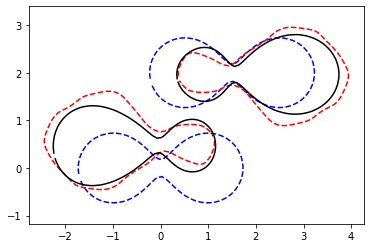

In [10]:
shape0_defo = out[0][0]
shape1_defo = out[1][0]

source = [source0, source1]
target = [target0, target1]

plt.plot(source[0][:,0].detach(), source[0][:,1].detach(), '--b')
plt.plot(source[1][:,0].detach(), source[1][:,1].detach(), '--b')
plt.plot(target[0][:,0].detach(), target[0][:,1].detach(), '--r')
plt.plot(target[1][:,0].detach(), target[1][:,1].detach(), '--r')
plt.plot(shape0_defo[:,0].detach(), shape0_defo[:,1].detach(), '-k')
plt.plot(shape1_defo[:,0].detach(), shape1_defo[:,1].detach(), '-k')
plt.axis('equal')
plt.show()

In [11]:
fac = 2
grid_resolution = [fac*9, fac*4]
gridmod = dm.DeformationModules.DeformationGrid(dm.Utilities.AABB.build_from_points(torch.cat([source[0], source[1]])).scale([1.5,1.]), grid_resolution)

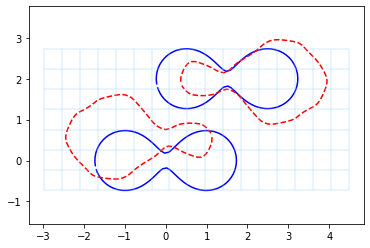

In [12]:
grid = gridmod.togrid()

ax = plt.subplot()
plt.plot(source[0][:,0].detach(), source[0][:,1].detach(), '-b')
plt.plot(source[1][:,0].detach(), source[1][:,1].detach(), '-b')
plt.plot(target[0][:,0].detach(), target[0][:,1].detach(), '--r')
plt.plot(target[1][:,0].detach(), target[1][:,1].detach(), '--r')

dm.Utilities.plot_grid(ax, grid[0], grid[1], color='xkcd:light blue', lw=0.4)
plt.axis('equal')
plt.show()

In [17]:
boundary0 = dm.MultiShape.Boundary(copy.copy(source[0][::2]))
boundary1 = dm.MultiShape.Boundary(copy.copy(source[1][::2]))

In [18]:
ind_grid_0 = torch.where(boundary0.isin_label(gridmod.manifold.gd)==True)
ind_grid_1 = torch.where(boundary1.isin_label(gridmod.manifold.gd)==True)
ind_grid_bck = torch.where((boundary0.isin_label(gridmod.manifold.gd)==False)*(boundary1.isin_label(gridmod.manifold.gd)==False)==True)

In [19]:
pts_0 = gridmod.manifold.gd[ind_grid_0].clone().contiguous()
pts_1 = gridmod.manifold.gd[ind_grid_1].clone().contiguous()
pts_bck = gridmod.manifold.gd[ind_grid_bck].clone().contiguous()

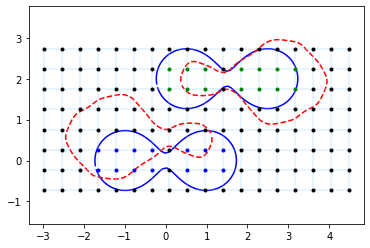

In [20]:

ax = plt.subplot()
plt.plot(source[0][:,0].detach(), source[0][:,1].detach(), '-b')
plt.plot(source[1][:,0].detach(), source[1][:,1].detach(), '-b')
plt.plot(target[0][:,0].detach(), target[0][:,1].detach(), '--r')
plt.plot(target[1][:,0].detach(), target[1][:,1].detach(), '--r')

dm.Utilities.plot_grid(ax, grid[0], grid[1], color='xkcd:light blue', lw=0.4)
plt.plot(pts_0[:,0].detach(), pts_0[:,1].detach(), '.b')
plt.plot(pts_1[:,0].detach(), pts_1[:,1].detach(), '.g')
plt.plot(pts_bck[:,0].detach(), pts_bck[:,1].detach(), '.k')

plt.axis('equal')
plt.show()

In [21]:
module_list = model.modules
for i, mod in enumerate(module_list):
    mod.manifold.fill_gd(model.init_manifold[i].gd)
    mod.manifold.fill_cotan(model.init_manifold[i].cotan)

In [22]:
grid0_deformable = dm.Models.DeformablePoints(pts_0)
grid1_deformable = dm.Models.DeformablePoints(pts_1)
gridbck_deformable = dm.Models.DeformablePoints(pts_bck)
grids_deformable = [grid0_deformable, grid1_deformable, gridbck_deformable]

In [23]:
module_list_grid = []
for mod, defgrid in zip(module_list[:-1], grids_deformable[:-1]):
    module_list_grid.append(dm.DeformationModules.CompoundModule([mod[0], defgrid.silent_module, *mod[1:]]))
module_list_grid.append(dm.DeformationModules.CompoundModule([*module_list[-1], grids_deformable[-1].silent_module]))

In [24]:
compound_man_grid = dm.MultiShape.MultishapeCompoundManifold.MultishapeCompoundManifold([dm.Manifolds.CompoundManifold([source_deformable0.silent_module.manifold.clone(requires_grad=True), grid0_deformable.silent_module.manifold.clone(requires_grad=True), scaling00.manifold.clone(requires_grad=True), scaling01.manifold.clone(requires_grad=True), translation0.manifold.clone(requires_grad=True), boundary0.silent_module.manifold.clone(requires_grad=True)]), 
                                                                                                             dm.Manifolds.CompoundManifold([source_deformable1.silent_module.manifold.clone(requires_grad=True), grid1_deformable.silent_module.manifold.clone(requires_grad=True), scaling10.manifold.clone(requires_grad=True), scaling11.manifold.clone(requires_grad=True), translation1.manifold.clone(requires_grad=True), boundary1.silent_module.manifold.clone(requires_grad=True)]), 
                                                                                         dm.Manifolds.CompoundManifold([boundary0.silent_module.manifold.clone(requires_grad=True), boundary1.silent_module.manifold.clone(requires_grad=True), gridbck_deformable.silent_module.manifold.clone(requires_grad=True)])])
sigma_bck = 0.5

In [25]:
constraints0_grid = dm.Constraints.Constraints.ConstraintsPointIdentityBackground(0, compound_man_grid)
constraints1_grid = dm.Constraints.Constraints.ConstraintsPointIdentityBackground(1, compound_man_grid)
constraints_grid = dm.Constraints.Constraints.CompoundConstraints([constraints0_grid, constraints1_grid])

In [26]:
multishape_grid = dm.MultiShape.MultiShape.MultiShapeModules(module_list_grid, sigma_bck)
Ham_grid = MultiShapeHamiltonian.Hamiltonian_multishape(multishape_grid, constraints_grid)
shoot(Ham_grid, shoot_solver, shoot_it)
shape0_defo_grid = Ham_grid.module.modules[0][0].manifold.gd
shape1_defo_grid = Ham_grid.module.modules[1][0].manifold.gd

In [27]:
grid0_deformed_pts = Ham_grid.module.modules[0][1].manifold.gd
grid1_deformed_pts = Ham_grid.module.modules[1][1].manifold.gd
gridbck_deformed_pts = Ham_grid.module.modules[2][-1].manifold.gd

In [28]:
gridmod.manifold.gd[ind_grid_0] = grid0_deformed_pts.clone()
gridmod.manifold.gd[ind_grid_1] = grid1_deformed_pts.clone()
gridmod.manifold.gd[ind_grid_bck] = gridbck_deformed_pts.clone()

In [29]:
grid_deformed = gridmod.togrid()

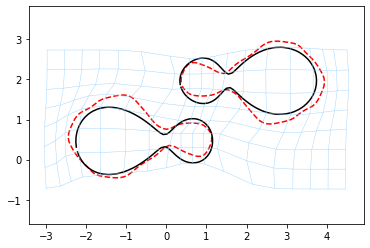

In [30]:
ax = plt.subplot()
#plt.plot(source[0][:,0].detach(), source[0][:,1].detach(), '-b')
#plt.plot(source[1][:,0].detach(), source[1][:,1].detach(), '-b')
plt.plot(target[0][:,0].detach(), target[0][:,1].detach(), '--r')
plt.plot(target[1][:,0].detach(), target[1][:,1].detach(), '--r')
plt.plot(shape0_defo_grid[:,0].detach(), shape0_defo[:,1].detach(), '-k')
plt.plot(shape1_defo_grid[:,0].detach(), shape1_defo[:,1].detach(), '-k')

dm.Utilities.plot_grid(ax, grid_deformed[0], grid_deformed[1], color='xkcd:light blue', lw=0.4)
plt.axis('equal')
plt.show()